## Target Process Simulation

We have a periodic $L$-lattice with an initial configuration of $\{1, \cdots, 1\}$. From a site with $k$ dots to a site with $\ell$ dots, the rate of transfer is given by $W_{k,\ell} = (1-\delta_{k,0})(1-\delta_{\ell,0})$, yet this transfer does not effectively cooperate with the known factorization schemes in target-process theory. Hence, we consider, instead, the rate $$W_{k,\ell} = (1-\delta_{k,0})v_\ell,$$ where $v_\ell = e^{-\beta}$ if $\ell$ is zero and $v_\ell=1$ otherwise. The primary prediction of this form is $$\mathbb{P}(\{n_k\})=Z_{L,N}^{-1} e^{-N_s\beta},$$ where $N_s$ is the number of stacks, i.e., the number of sites with dots on them. The purpose of this simulation is to test this hypothesis.

Running a simulation $M$ times should result in $$\text{\# of outcomes with }N_s\text{ stacks}\propto e^{-N_s\beta},$$ where each simulation is ran long enough as to reach a final state.

In [1]:
import random
import json
import numpy as np
import math
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 300

### Configuration Class

The abstract representation of a particular arrangement of particles around a circle of $L$ sites, equipped with the appropriate behaviors as methods.

In [2]:
class Configuration:
    ################################# INITIALIZATION #################################
    # initializes a configuration with a given number of sites and one particle per site
    def __init__(self, num_of_sites):
        self.num_of_sites = num_of_sites
        self.data = [1] * num_of_sites

    def from_string(self, config_string):
        string_to_list = json.loads(config_string)
        self.num_of_sites = len(string_to_list)
        self.data = [int(x) for x in string_to_list]
    
    ##################################### GETTERS #####################################
    # returns number of particles in the configuration (equal to number of sites, in default case)
    def get_num_of_particles(self):
        return sum(self.data)
    
    # returns number of empty sites in the configuration
    def get_num_of_empty_sites(self):
        return self.data.count(0)
    
    # returns number of occupied sites in the configuration, correlated sometimes with the number of "stacks"
    def get_num_of_occupied_sites(self):
        return self.num_of_sites - self.get_num_of_empty_sites()
    
    # returns a list of indices of empty sites
    def get_empty_sites(self):
        return [i for i, x in enumerate(self.data) if x == 0]
    
    # returns a list of indices of occupied sites
    def get_occupied_sites(self):
        return [i for i, x in enumerate(self.data) if x != 0]

    # returns a list of indices of occupied sites that have at least one neighbor occupied
    def get_occupied_sites_with_neighbors(self):
        return [
            i for i in self.get_occupied_sites() if
            (self.data[(i - 1) % self.num_of_sites] != 0 or self.data[(i + 1) % self.num_of_sites] != 0)
        ]
    
    # returns a list of occupied neighbors of a given site index
    def get_occupied_neighbors(self, index):
        left_neighbor = (index - 1) % self.num_of_sites
        right_neighbor = (index + 1) % self.num_of_sites
        return [
            i for i in [left_neighbor, right_neighbor] if self.data[i] != 0
        ]

    ##################################### SELECTORS #####################################
    # selects a random index of an occupied site
    def select_random_occupied_site(self):
        occupied_indices = self.get_occupied_sites()
        if occupied_indices:
            return random.choice(occupied_indices)
        else:
            raise ValueError("No occupied sites available to select from.")
    
    # selects a random index of an occupied site, with the constraint that at least one neighbor must be occupied
    # i.e., the selected site must have at least one neighbor that is occupied. this will be the departure site.
    def select_random_occupied_site_with_neighbor(self):
        occupied_indices = self.get_occupied_sites()
        if len(occupied_indices) == 0:
            raise ValueError("No occupied sites available to select from.")
        
        occupied_indices_with_neighbors = self.get_occupied_sites_with_neighbors()
        if len(occupied_indices_with_neighbors) == 0:
            return -1   # represents that the process cannot continue, as no occupied site has a neighbor
                        # i.e, we have reached an absorbing state
        else:
            return random.choice(occupied_indices_with_neighbors)

    # selects a pair of departure and arrival sites, i.e., a pair of indices such that the first index is an occupied site
    # with at least one neighbor occupied, and the second index is one of the occupied neighbors of the first index
    def select_departure_and_arrival_sites(self):
        departure_index = self.select_random_occupied_site_with_neighbor()
        if departure_index == -1:
            return -1, -1 # indicates that the process cannot continue, as no occupied site has a neighbor
        
        occupied_neighbors = self.get_occupied_neighbors(departure_index)
        if len(occupied_neighbors) == 0:
            raise ValueError("No occupied neighbors available for the selected departure site.")
        
        arrival_index = random.choice(occupied_neighbors)
        return departure_index, arrival_index
    
    ##################################### EVOLVERS #####################################
    # evolves the configuration by moving a particle from a departure site to an arrival site
    def evolve(self):
        departure_index, arrival_index = self.select_departure_and_arrival_sites()
        if departure_index == -1:
            return False # indicates that the process cannot continue, as no occupied site has a neighbor
        
        # move the particle from departure to arrival
        self.data[departure_index] -= 1
        self.data[arrival_index] += 1
        return True
    
    # evolves the configuration until it reaches an absorbing state, i.e., no occupied site has a neighbor
    # can shoot off to infinity in rare cases, but practically it will reach an absorbing state in finite time
    def evolve_until_absorbing_state(self):
        time_steps = 0
        while self.evolve():
            time_steps += 1
        return time_steps, self.data

    ##################################### CHECKERS #####################################
    # the purpose of this section of methods is to check if two different configurations are equal,
    # up to rotational and reflectional symmetry (i.e., under the action of the dihedral group D_2n)
    def is_equal_to(self, other):
        if self.num_of_sites != other.num_of_sites:
            return False
        
        for _ in range(self.num_of_sites):
            if self.data == other.data:
                return True
            # rotate the other configuration
            other.data = other.data[1:] + other.data[:1]
        
        # check reflection
        reflected_other = other.data[::-1]
        for _ in range(self.num_of_sites):
            if self.data == reflected_other:
                return True
            # rotate the reflected configuration
            reflected_other = reflected_other[1:] + reflected_other[:1]
        
        return False
        

In [3]:
class ManyConfigurationExperiment:
    def __init__(self, num_of_sites):
        self.num_of_sites = num_of_sites
        self.data = {                                           # dictionary to store configurations and their counts, 
                                                # where keys are configurations as strings and values are an array of time steps to reach absorbing state
            str([num_of_sites] + [0]*(num_of_sites - 1)): []    # initial configuration with all particles at the first site
        }
    
    def run_trial(self):
        config = Configuration(self.num_of_sites)
        time_steps, data = config.evolve_until_absorbing_state()

        configuration_already_exists = False
        for key in self.data.keys():
            existing_config = Configuration(self.num_of_sites)
            existing_config.from_string(key)
            if existing_config.is_equal_to(config):
                self.data[key].append(time_steps)
                configuration_already_exists = True
                break
        
        if not configuration_already_exists:
            self.data[str(config.data)] = [time_steps]
    
    def run_trials(self, num_of_trials):
        for _ in range(num_of_trials):
            self.run_trial()
    
    def get_data_of_k_occupied_sites(self, k):
        new_data = {}
        for key, time_steps in self.data.items():
            config = Configuration(self.num_of_sites)
            config.from_string(key)
            if config.get_num_of_occupied_sites() == k:
                new_data[key] = time_steps
        return new_data

    def get_num_of_trials(self):
        return sum(len(time_steps) for time_steps in self.data.values())
    
    def get_number_of_events_in_each_configuration(self, map=None):
        if map is None:
            map = {key: len(value) for key, value in self.data.items()}
        else:
            map = {key: len(value) for key, value in map.items()}
        return map

    def get_probabilities_of_each_configuration(self, map=None):
        if map is None:
            map = {key: len(value)/self.get_num_of_trials() for key, value in self.data.items()}
        else:
            map = {key: len(value)/self.get_num_of_trials() for key, value in map.items()}
        return map
    
    def get_number_of_absorbing_states(self):
        return len(self.data)
    
    def get_probability_of_k_occupied_sites(self, k):
        total_trials = self.get_num_of_trials()
        if total_trials == 0:
            return 0
        k_data = self.get_data_of_k_occupied_sites(k)
        k_trials = sum(len(time_steps) for time_steps in k_data.values())
        return k_trials / total_trials if k_trials > 0 else 0
    
    def get_most_probable_absorbing_state(self):
        probabilities = self.get_probabilities_of_each_configuration()
        most_probable_state = max(probabilities, key=probabilities.get)
        return most_probable_state, probabilities[most_probable_state]

In [4]:
Sites = 10                           # number of sites
Trials = 10_000                     # number of trials to run

# Data = {                                # dictionary to store configurations and their counts, 
#                                         # where keys are configurations as strings and values are an array of time steps to reach absorbing state
#     str([Sites] + [0]*(Sites - 1)): []  # initial configuration with all particles at the first site
# }

Data = ManyConfigurationExperiment(Sites)
Data.run_trials(Trials)

In [5]:
print("Number of absorbing states reached:", Data.get_number_of_absorbing_states())

Number of absorbing states reached: 169


In [6]:
Data.get_probabilities_of_each_configuration(
    # Data.get_data_of_k_occupied_sites(2)
)

{'[10, 0, 0, 0, 0, 0, 0, 0, 0, 0]': 0.0,
 '[0, 4, 0, 0, 3, 0, 0, 3, 0, 0]': 0.0737,
 '[3, 0, 2, 0, 2, 0, 3, 0, 0, 0]': 0.0113,
 '[3, 0, 1, 0, 2, 0, 4, 0, 0, 0]': 0.0155,
 '[0, 0, 5, 0, 0, 0, 0, 5, 0, 0]': 0.0058,
 '[4, 0, 0, 4, 0, 0, 0, 2, 0, 0]': 0.0243,
 '[0, 1, 0, 2, 0, 2, 0, 2, 0, 3]': 0.0086,
 '[3, 0, 2, 0, 0, 3, 0, 0, 2, 0]': 0.0203,
 '[1, 0, 3, 0, 1, 0, 3, 0, 2, 0]': 0.0086,
 '[0, 2, 0, 0, 4, 0, 0, 0, 4, 0]': 0.0215,
 '[0, 6, 0, 0, 0, 3, 0, 0, 1, 0]': 0.003,
 '[1, 0, 5, 0, 0, 0, 0, 0, 4, 0]': 0.0042,
 '[2, 0, 1, 0, 4, 0, 0, 0, 3, 0]': 0.0137,
 '[0, 0, 2, 0, 5, 0, 0, 0, 3, 0]': 0.003,
 '[1, 0, 3, 0, 0, 3, 0, 0, 3, 0]': 0.0212,
 '[0, 0, 0, 0, 4, 0, 1, 0, 0, 5]': 0.0106,
 '[3, 0, 2, 0, 0, 0, 5, 0, 0, 0]': 0.0313,
 '[3, 0, 0, 4, 0, 0, 0, 0, 3, 0]': 0.0159,
 '[3, 0, 0, 3, 0, 0, 2, 0, 2, 0]': 0.0426,
 '[0, 0, 4, 0, 0, 0, 4, 0, 2, 0]': 0.0214,
 '[6, 0, 0, 0, 0, 0, 4, 0, 0, 0]': 0.0077,
 '[2, 0, 0, 4, 0, 0, 2, 0, 2, 0]': 0.017,
 '[3, 0, 0, 0, 3, 0, 0, 4, 0, 0]': 0.0192,
 '[0, 3, 0, 1, 0

Text(0, 0.5, 'Probability of Reaching Absorbing State')

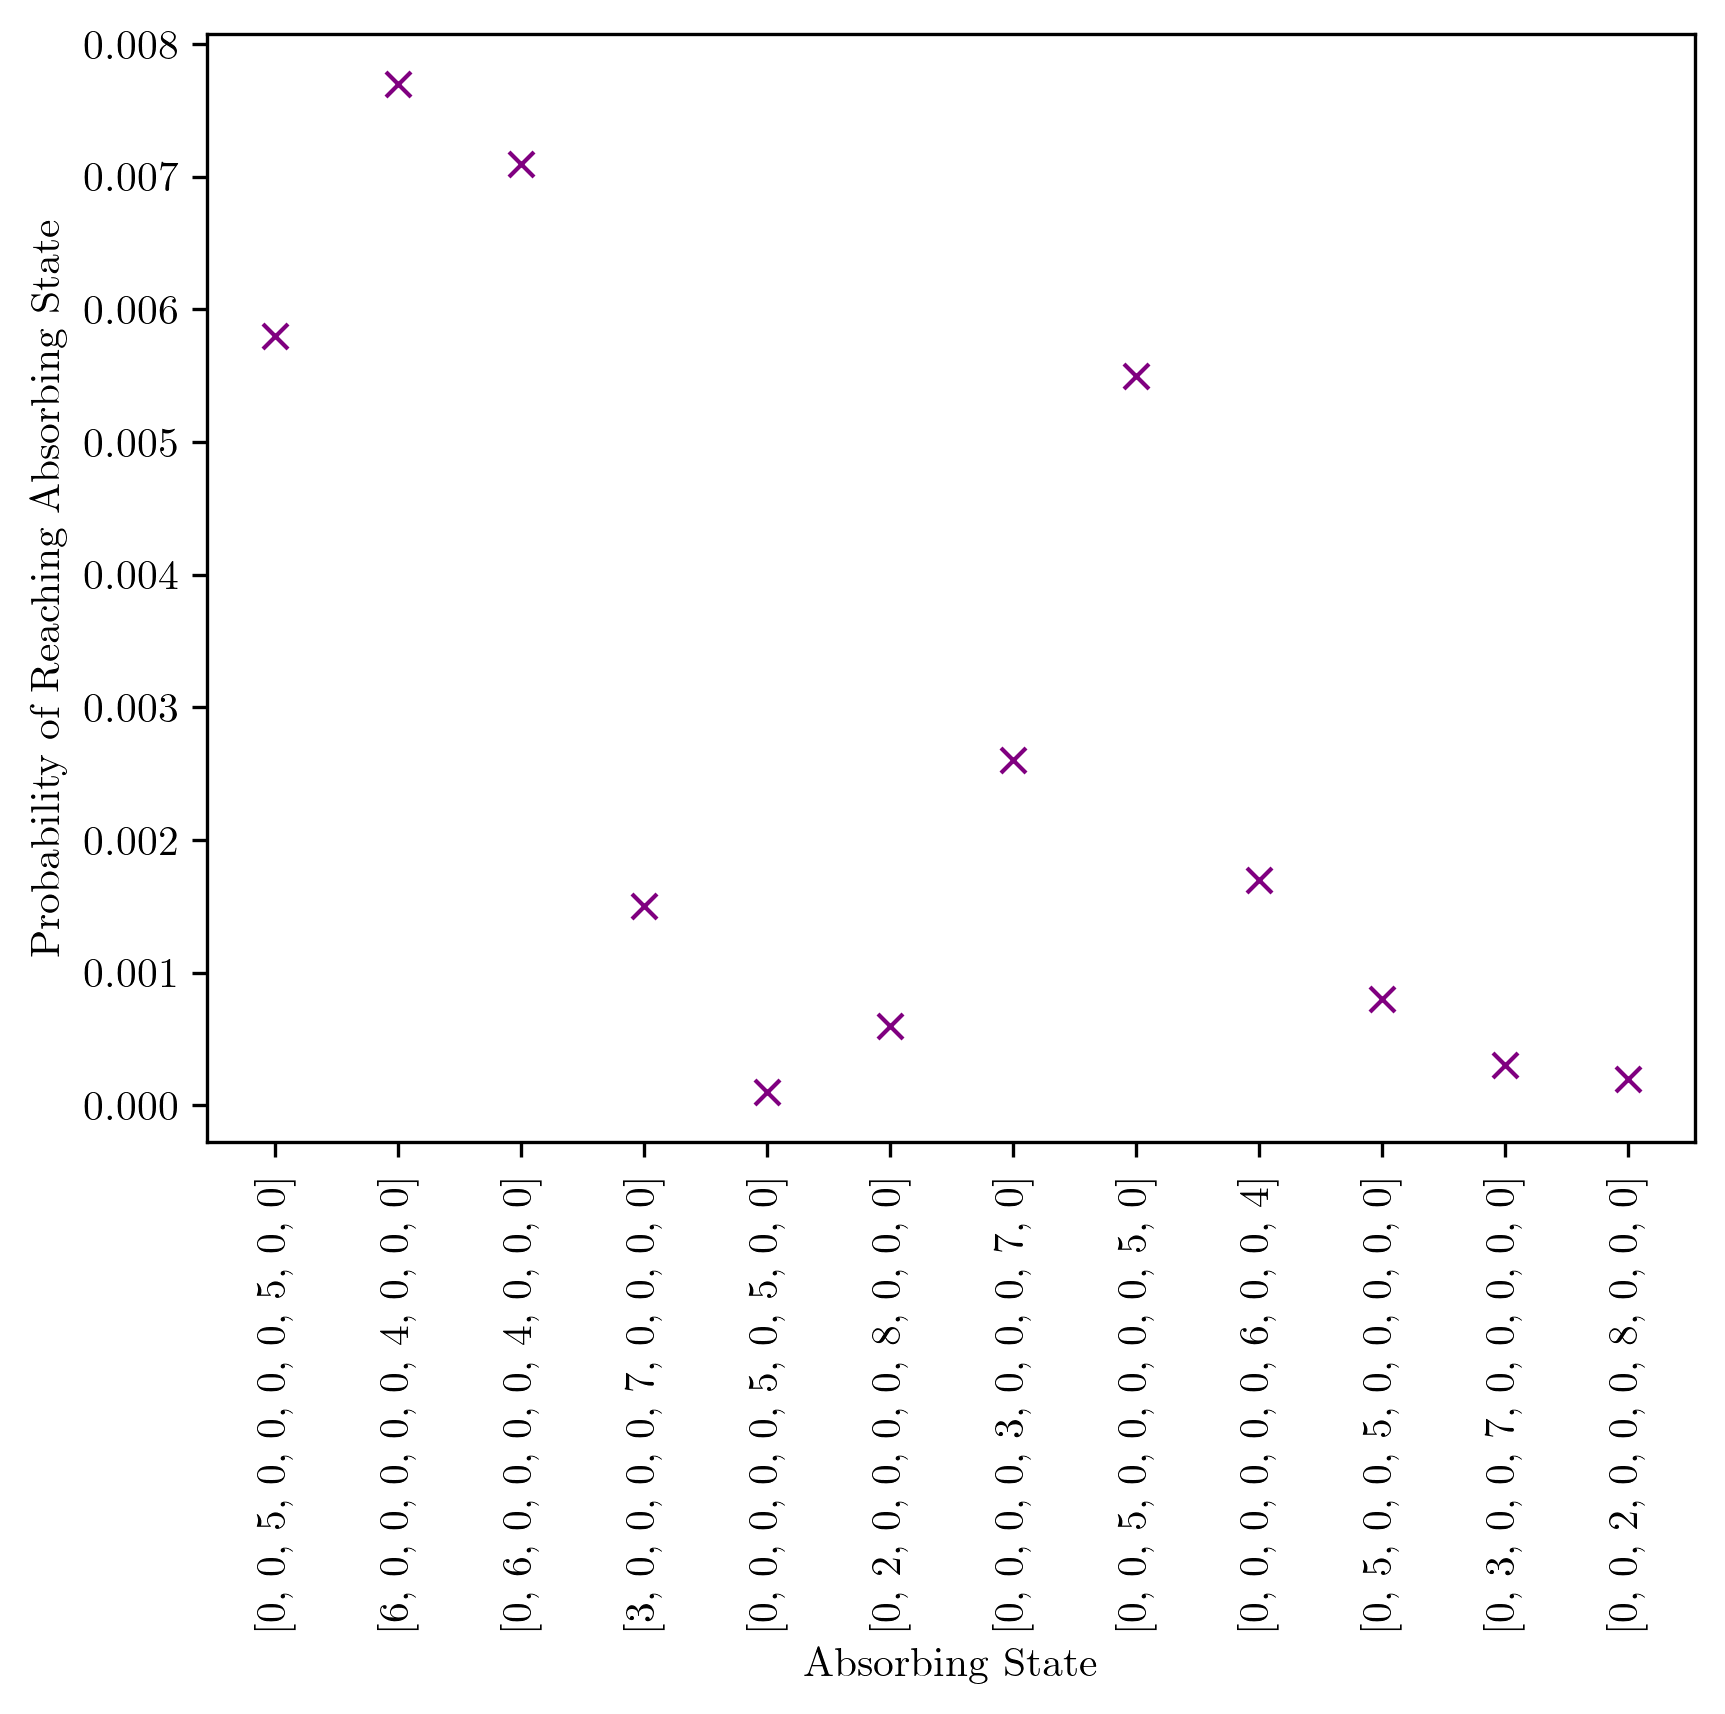

In [8]:
k = 2

Configurations = list(Data.get_probabilities_of_each_configuration(
    Data.get_data_of_k_occupied_sites(k)
).keys())
Probabilities = list(Data.get_probabilities_of_each_configuration(
    Data.get_data_of_k_occupied_sites(k)
).values())
plt.plot(Configurations, Probabilities, 'x', markersize=6, color='purple')
plt.xticks(rotation=90)
plt.xlabel("Absorbing State")
plt.ylabel("Probability of Reaching Absorbing State")

**Questions:**
1. What is the experimental probability of getting $N_s$ stacks at the end of the experiment?
2. Is the result that $\mathbb{P}(\{n_\ell\})\propto e^{-\beta N_s}$ true in the case that the rate is $e^{-\beta}$ instead of zero?
3. Is the above result true in the asymptotic limit $L\to\infty$? Numerically, we might try $L\approx 100$ or $L\approx 1000$.
4. Are there more clever ways of simulating this so that the long relaxation time constraint can be reduced? Maybe by making note of cycles and implicitly calculating for them?
5. Is the step-by-step evolution against a more continuous, asynchronous evolutionary process?
6. What is the form of the most likely configuration?

#### **Question 1**: $\mathbb{P}(N_s) =$ ?

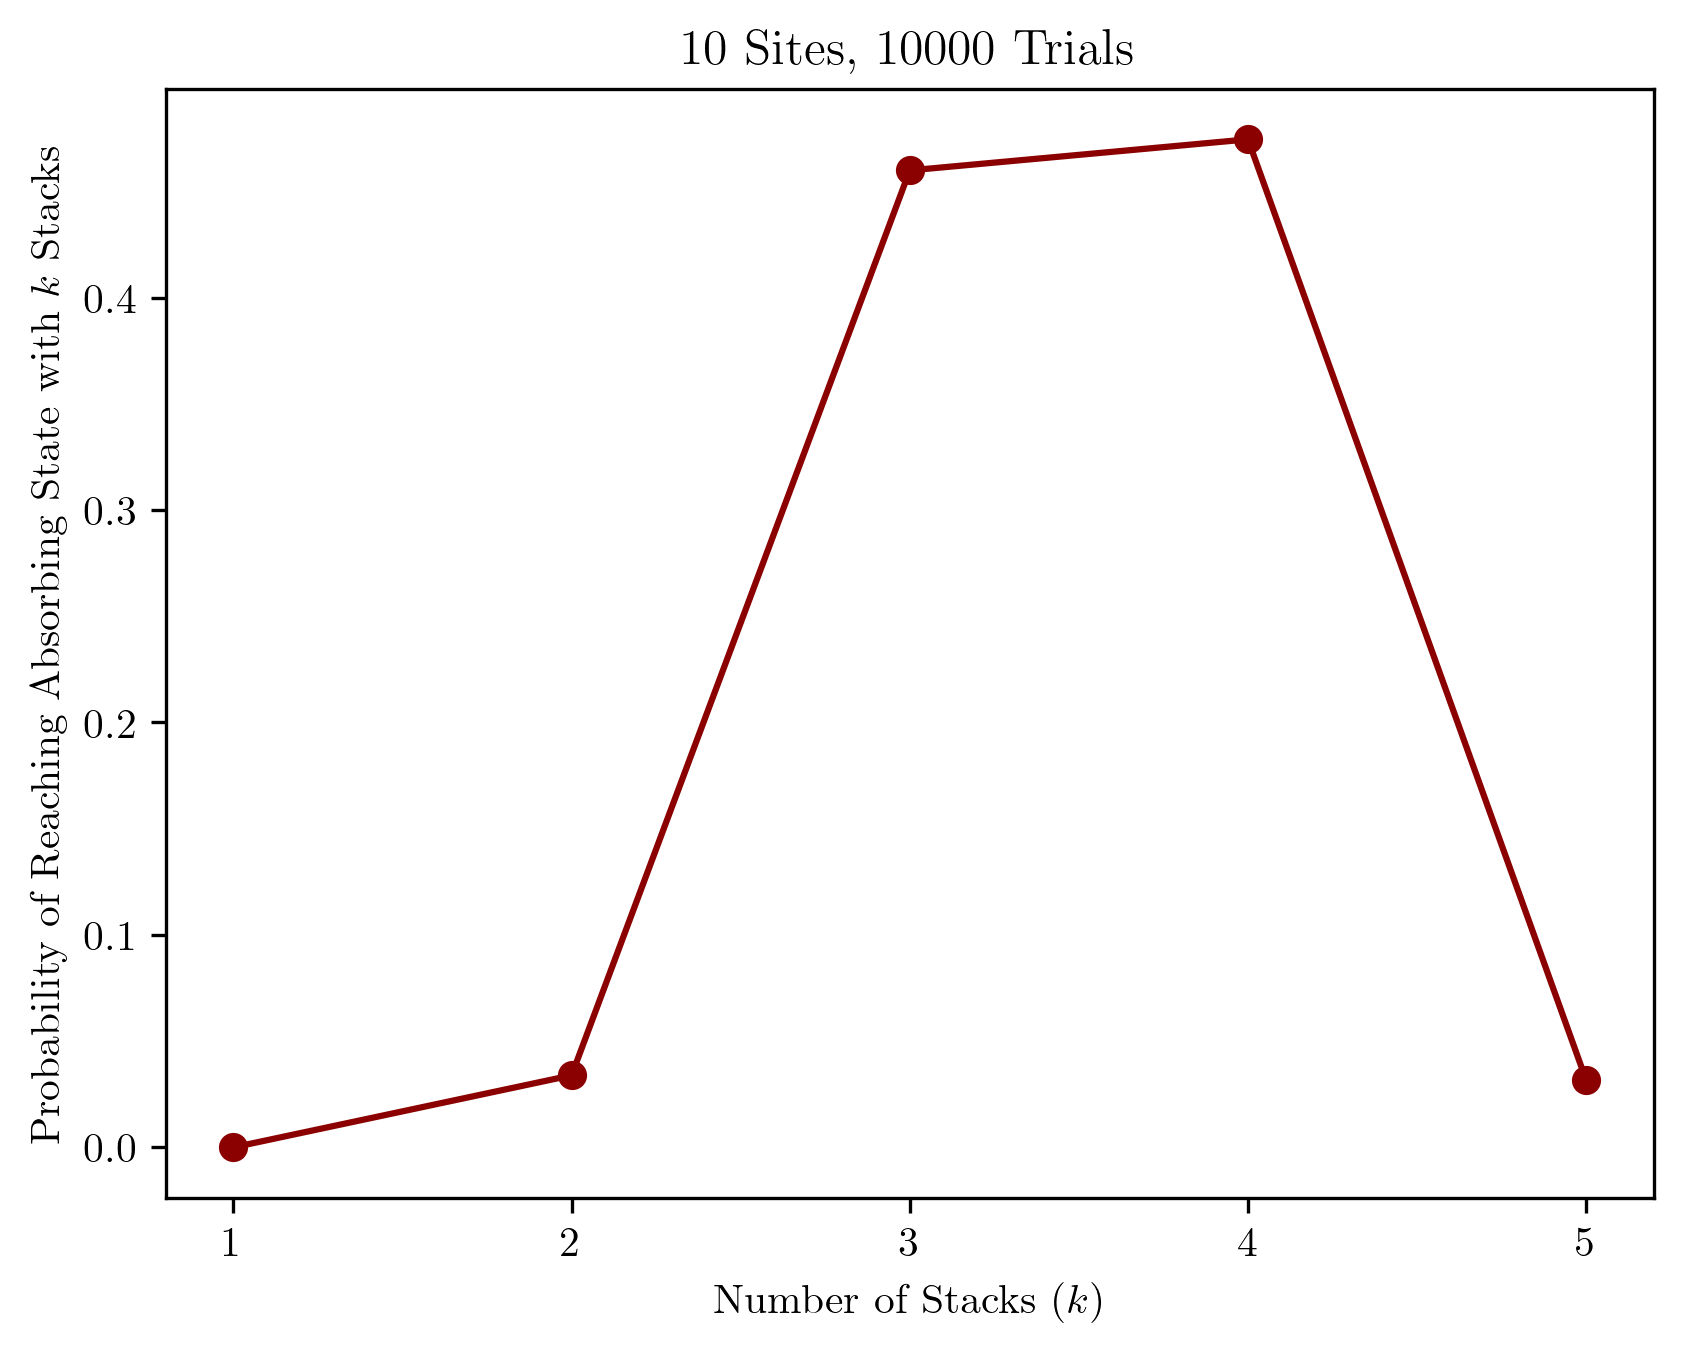

In [9]:
max_num_of_stacks = math.ceil(Sites / 2)
StackNumber = np.arange(1, max_num_of_stacks + 1)
Probabilities = [Data.get_probability_of_k_occupied_sites(k) for k in StackNumber]

plt.plot(StackNumber, Probabilities, 'o-', markersize=6, color='darkred')
plt.xlabel("Number of Stacks ($k$)")
plt.ylabel("Probability of Reaching Absorbing State with $k$ Stacks")
plt.title(f"{Sites} Sites, {Trials} Trials")
plt.xticks(StackNumber)
None

#### **Question 6**: What is the form of the most likely absorbing state?

The following data is collected from experiments run with 100,000 trials
| $L$ sites | Most Probable Configuration | Probability |
| --------- | --------------------------- | ----------- |
| 4 | [4, 0, 0, 0] | 0.62519 |
| 5 | [0, 3, 0, 0, 2] | 0.55805 |
| 6 | [4, 0, 0, 2, 0, 0] | 0.19785 |
| 7 | [4, 0, 0, 0, 3, 0, 0] | 0.28128 |
| 8 | [0, 3, 0, 0, 2, 0, 3, 0] | 0.15735 |
| 9 | [3, 0, 0, 2, 0, 0, 4, 0, 0] | 0.08017 |
| 10 | [0, 0, 3, 0, 0, 4, 0, 0, 0, 3] | 0.07264 |
| 11 | [0, 3, 0, 0, 3, 0, 0, 2, 0, 3, 0] | 0.04469 |
| 12 | [4, 0, 0, 2, 0, 0, 3, 0, 0, 3, 0, 0] | 0.01925 |


Text(0, 0.5, 'Probability of Most Probable Absorbing State')

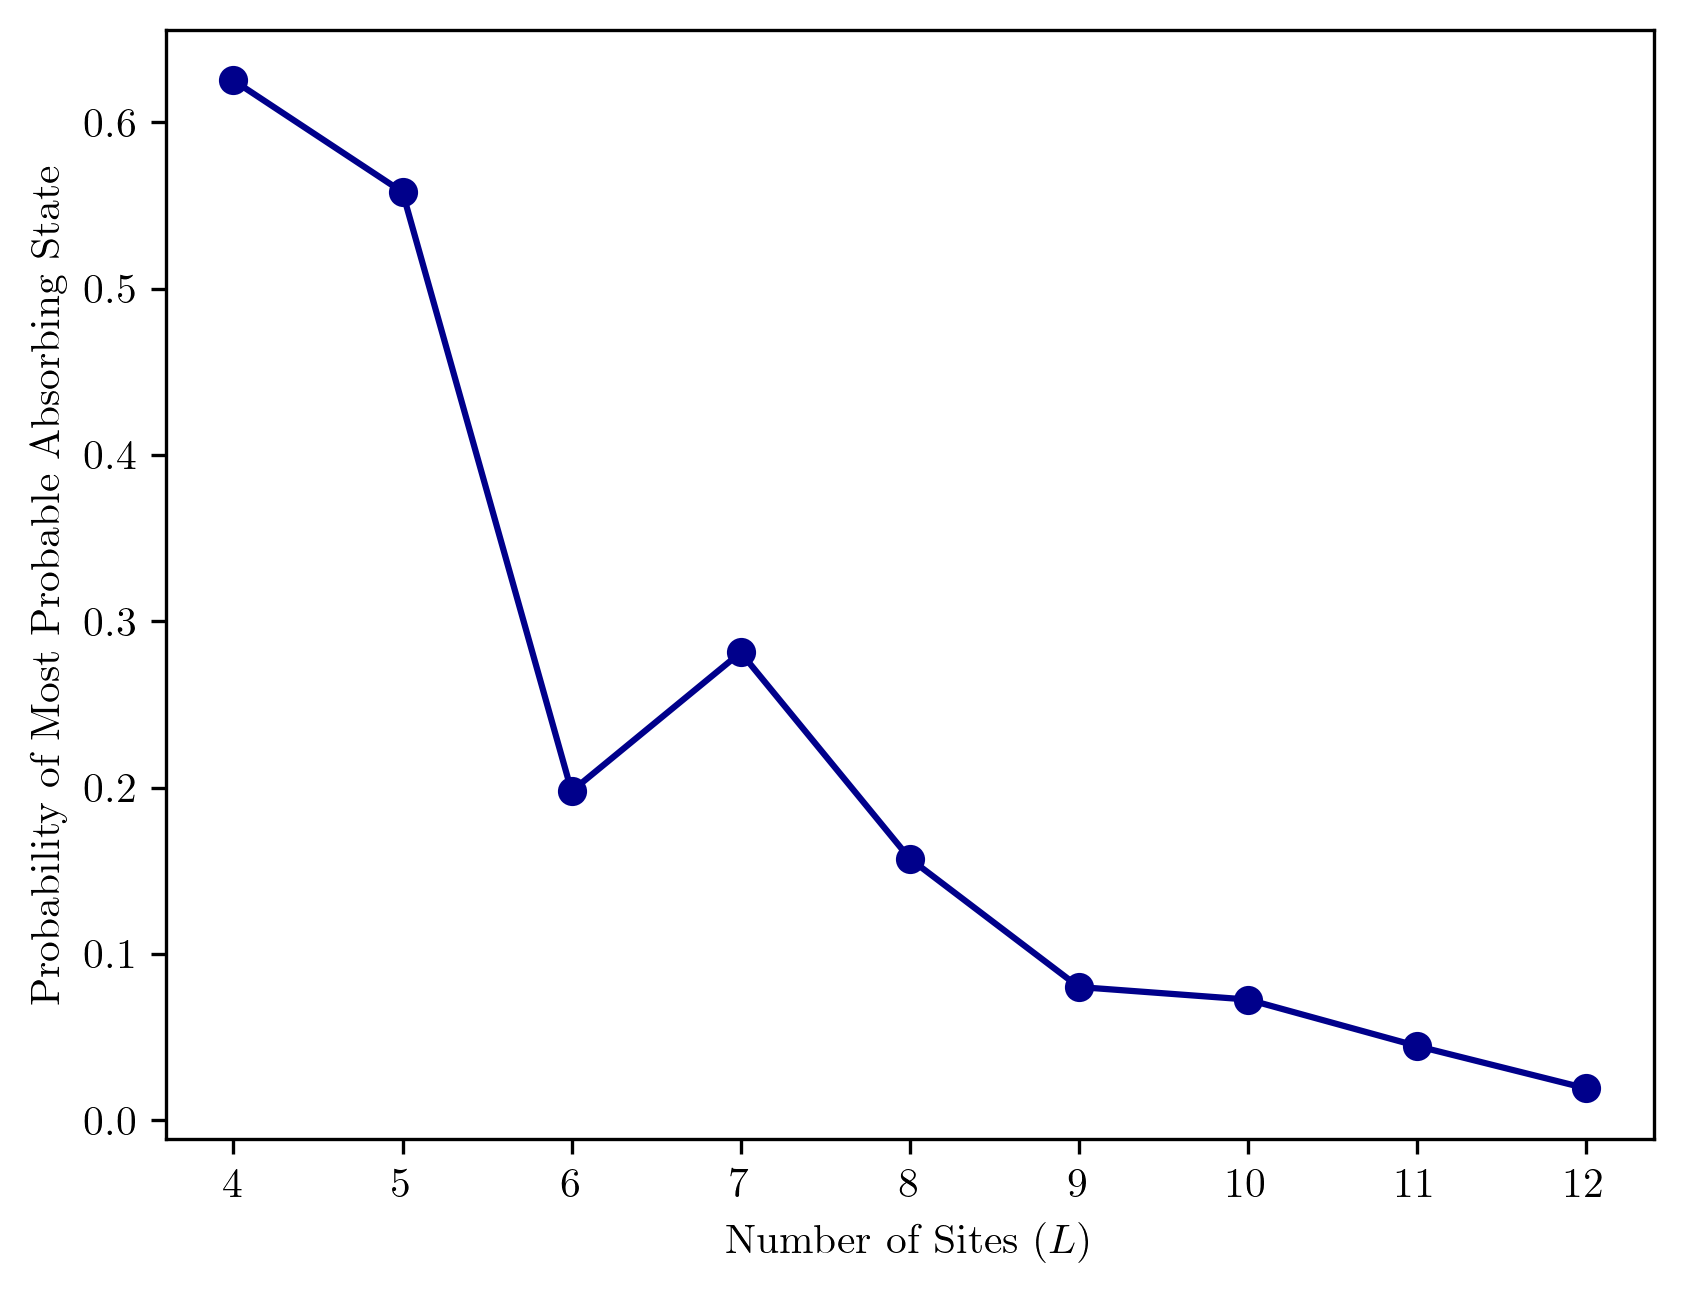

In [10]:
NumOfSites = np.arange(4, 12 + 1)
ProbabilityOfMostProbableAbsorbingState = [0.62519, 0.55805, 0.19785,0.28128, 0.15735, 0.08017, 0.07264, 0.04469, 0.01925]
plt.plot(NumOfSites, ProbabilityOfMostProbableAbsorbingState, 'o-', markersize=6, color='darkblue')
plt.xlabel("Number of Sites ($L$)")
plt.ylabel("Probability of Most Probable Absorbing State")

In [11]:
Data.get_most_probable_absorbing_state()

('[0, 4, 0, 0, 3, 0, 0, 3, 0, 0]', 0.0737)